## Benchmark halo.

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/high_res_1Halo'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

@nb.njit
def rho_crit(z):
    """Critical density of the universe as a function of redshift, assuming
    matter domination, only Omega_m and Omega_Lambda in Friedmann equation. See 
    notes for derivation.

    Args:
        z (array): redshift

    Returns:
        array: critical density at redshift z
    """    
    
    H_squared = FCT_H0**2 * (FCT_Omega_M*(1.+z)**3 + FCT_Omega_L) 
    rho_crit = 3.*H_squared / (8.*Pi*G)

    return np.float64(rho_crit)


def halo_sample_z(z, snap, Mvir_z0, DM_mass, out_dir):

    # Get the DM halo mass (and the number of DM particles for sample).
    commah_output = commah.run('Planck13', zi=0, Mi=Mvir_z0, z=z)
    Mz = commah_output['Mz'][0,0]*Msun
    num_DM = math.floor(Mz / DM_mass)

    # Get the concentration of the halo.
    c_200 = commah_output['c'][0,0]

    # Calculate R_200 and R_s ("virial" radius and scale radius).
    R_200 = np.power(Mz / (200*rho_crit(z)*4/3*Pi), 1./3.)
    R_s = R_200 / c_200

    # Construct projection function.
    def Proj(r, r_s, norm):
        x = r/r_s
        return (np.log(1+x) - (x/(1+x)))/norm

    # Construct inverse function. Needs to be without numerical units.
    f_200 = np.log(1+c_200) - (c_200/(1+c_200))
    invf = inversefunc(Proj, args=(R_s/kpc, f_200))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian coordinates.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z))

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)


benchmark_outdir = f'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files'
if not os.path.exists(benchmark_outdir):
    os.makedirs(benchmark_outdir)

with ProcessPoolExecutor(24) as ex:
    ex.map(
        halo_sample_z, zeds_snaps, nums_snaps,
        repeat(Mvir_MW/Msun), repeat(DM_mass), repeat(benchmark_outdir)
    )

In [ ]:
benchmark_DM = np.array([
    len(np.load(f'{benchmark_outdir}/benchmark_halo_snap_{num}.npy')) 
    for num in nums_snaps
])

print(np.log10(Mvir_MW/Msun), np.log10(DM_mass*benchmark_DM[-1]/Msun))

nums_proxy = np.arange(12, 36+1)
plt.plot(nums_proxy, benchmark_DM); plt.show()

## Run scripts.

### all_sky sim type tests.

In [ ]:
!python make_simulation_parameters.py \
--sim_dir L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
--sim_type all_sky \
--healpix_nside 2 \
--nu_mass_start 0.01 \
--nu_mass_stop 0.3 \
--nu_mass_num 100 \
--nu_sim_mass 0.3 \
--p_start 0.01 \
--p_stop 400 \
--p_num 10_000 \
--init_x_dis 8.5 \
--z_int_shift 0.1 \
--z_int_stop 4 \
--z_int_num 100 \
--int_solver RK23 \
--CPUs_precalculations 128 \
--CPUs_simulations 128 \
--memory_limit_GB 224 \
--DM_in_cell_limit 10_000

In [ ]:
from shared.preface import *

arr = np.load('L025N752/DMONLY/SigmaConstant00/low_res_all_sky/initial_velocities.npy')
print(arr.itemsize*arr.size/1e6)
print(arr.shape)

In [ ]:
print(os.getcwd())

In [ ]:
!python simulation_analytical.py \
-d L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
-st all_sky \
--MW_halo \
--no-VC_halo \
--no-AG_halo

In [ ]:
from shared.preface import *
arr = np.load('L025N752/DMONLY/SigmaConstant00/low_res_all_sky/number_densities_analytical_all_sky.npy')
print(arr.shape)

In [ ]:
!python simulation_numerical.py \
-d L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
-st all_sky \
-mg 12.0 \
-mr 0.6 \
-hn 1

### single_halos & benchmark sim type tests.

In [ ]:
!python simulation_analytical.py -d L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark -st single_halos --MW_halo --no-VC_halo --no-AG_halo

In [ ]:
!python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00/high_res_1Halo -st single_halos -mg 12.0 -mr 0.6 -hn 1

## Load, transform and plot simulation outputs.

ic| DM_obs_cent: array([[-1.5, 10. , 10. ]])
ic| glat_rad: array([0.77983563])
ic| glon_rad: array([1.71968627])


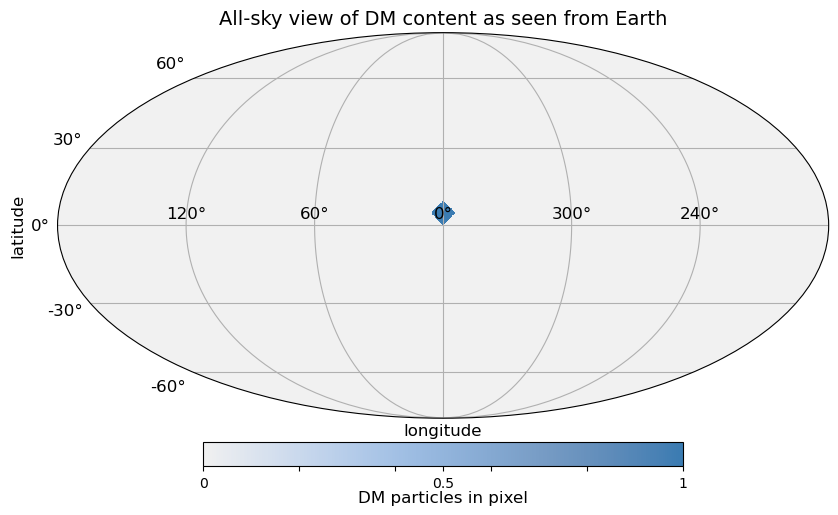

<Figure size 800x800 with 0 Axes>

In [63]:
from shared.preface import *
from shared.shared_functions import *

class analyze_simulation_outputs(object):

    def __init__(self, sim_dir, objects, sim_type):

        # Required:
        self.sim_dir = sim_dir
        self.objects = objects
        self.sim_type = sim_type
        
        self.fig_dir = f'figures/{sim_dir}'
        if not os.path.exists(self.fig_dir):
            os.makedirs(self.fig_dir)


        # Neccessary arrays.
        self.mrange = np.load(f'{self.sim_dir}/neutrino_massrange_eV.npy')*eV
        self.mpicks = np.array([0.01, 0.05, 0.1, 0.3])

        if self.sim_type == 'single_halos':

            if 'NFW_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_numerical_benchmark_halo_batch*.npy'
                )
                
                self.vectors_benchmark = []
                for batch_path in batch_paths:
                    self.vectors_benchmark.append(np.load(batch_path))
                self.vectors_benchmark = np.squeeze(
                    np.array(self.vectors_benchmark)
                )
                self.vectors_benchmark = np.array(self.vectors_benchmark)

                self.etas_benchmark = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo.npy'
                )/N0


            if 'box_halos' in self.objects:
                
                self.etas_numerical = []
                self.vectors_numerical = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1): 
                    
                    # Find all batch paths belonging to current halo.
                    batch_paths = glob.glob(
                        f'{self.sim_dir}/neutrino_vectors_numerical_halo{halo}_batch*.npy'
                    )

                    # Concatenate all vector batches into one array.
                    vectors_halo = []
                    for batch_path in batch_paths:
                        vectors_halo.append(np.load(batch_path))
                    vectors_halo = np.squeeze(np.array(vectors_halo))

                    # Append vectors.
                    self.vectors_numerical.append(vectors_halo)

                    # Append overdensities.
                    self.etas_numerical.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}.npy'
                        )/N0
                    )

                self.etas_numerical = np.array(self.etas_numerical)
                self.vectors_numerical = np.array(self.vectors_numerical)


            if 'analytical_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_analytical_batch*.npy'
                )
                
                self.vectors_analytical = []
                for batch_path in batch_paths:
                    self.vectors_analytical.append(np.load(batch_path))
                self.vectors_analytical = np.squeeze(
                    np.array(self.vectors_analytical)
                )
                self.vectors_analytical = np.array(self.vectors_analytical)

                self.etas_analytical = np.load(
                    f'{self.sim_dir}/number_densities_analytical.npy'
                )/N0


        elif self.sim_type == 'all_sky':

            if 'box_halos' in self.objects:

                self.number_densities_numerical_all_sky = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))
                halo_num = 2  #! manual override for testing

                for halo in range(1, halo_num+1): 
                    
                    # Append overdensities.
                    self.number_densities_numerical_all_sky.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}_all_sky.npy'
                        )
                    )

                self.number_densities_numerical_all_sky = np.array(
                    self.number_densities_numerical_all_sky
                )


            if 'analytical_halo' in self.objects:

                self.number_densities_analytical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_analytical_all_sky.npy'
                )
            

    def plot_overdensity_band(self, plot_ylims:tuple):

        ### ------------- ###
        ### Setup figure. ###
        ### ------------- ###
        fig, ax = plt.subplots(1,1)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'Overdensity band')
        ax.set_xlabel(r'$m_{\nu}$ [meV]')
        ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
        ax.set_ylim(plot_ylims[0], plot_ylims[1])
        plt.grid(True, which="both", ls="-")

        savefig_args = dict(
            bbox_inches='tight'
        )


        ### ------------- ###
        ### Plot objects. ###
        ### ------------- ###

        if 'NFW_halo' in self.objects:

            plt.plot(
                self.mrange*1e3, self.etas_benchmark-1, 
                color='green', label='(Benchmark) NFW Halo'
            )

        if 'box_halos' in self.objects:

            etas_median = np.median(
                self.etas_numerical, axis=0)
            etas_perc2p5 = np.percentile(
                self.etas_numerical, q=2.5, axis=0)
            etas_perc97p5 = np.percentile(
                self.etas_numerical, q=97.5, axis=0)
            etas_perc16 = np.percentile(
                self.etas_numerical, q=16, axis=0)
            etas_perc84 = np.percentile(
                self.etas_numerical, q=84, axis=0)
            
            ax.plot(
                self.mrange*1e3, (etas_median-1), color='blue', 
                label='Box Halos: medians'
            )
            ax.fill_between(
                self.mrange*1e3, (etas_perc2p5-1), (etas_perc97p5-1), 
                color='blue', alpha=0.2, label='Box Halos: 2.5-97.5 % C.L.'
            )
            ax.fill_between(
                self.mrange*1e3, (etas_perc16-1), (etas_perc84-1), 
                color='blue', alpha=0.3, label='Box Halos: 16-84 % C.L.'
            )

        if 'analytical_halo' in self.objects:

            plt.plot(
                self.mrange*1e3, self.etas_analytical-1, 
                color='red', ls='solid', label='Analytical Halo'
            )

            # Plot endpoint values from Mertsch et al (2020).
            x_ends = [1e1, 3*1e2]
            y_ends = [3*1e-3, 4]
            ax.scatter(x_ends, y_ends, marker='x', s=15, color='orange')


        plt.legend(loc='lower right')
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
        plt.savefig(f'{self.fig_dir}/overdensity_band.pdf', **savefig_args)
        plt.close()


    def plot_overdensity_evolution(self, plot_ylims:tuple):

        ### ============= ###
        ### Setup figure. ###
        ### ============= ###

        fig, ax = plt.subplots(1,1, figsize=(8,12))
        ax.set_title('Overdensities (redshift) evolution')
        ax.set_xlabel('z')
        ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
        ax.set_yscale('log')
        ax.set_ylim(plot_ylims[0], plot_ylims[1])
        
        savefig_args = dict(
            bbox_inches='tight'
        )


        ### ============= ###
        ### Plot objects. ###
        ### ============= ###

        z_int_steps = np.load(f'{self.sim_dir}/z_int_steps.npy')
        colors = ['blue', 'orange', 'green', 'red']


        ### ---------------- ###
        ### Analytical halo. ###
        ### ---------------- ###

        # Convert velocities to mementa.
        p_arr_ana, _ = velocity_to_momentum(
            self.vectors_analytical[...,3:6], self.mpicks
        )

        # Overdensities for each redshift as if it was the last in the sim.
        inds = np.arange(p_arr_ana.shape[-1])
        etas_ana_zeds = np.array(
            [
                number_density(p_arr_ana[...,0], p_arr_ana[...,z]) 
                for z in inds
            ]
        ).T/N0

        for j, m in enumerate(self.mpicks):
            ax.plot(
                z_int_steps, etas_ana_zeds[j]-1, 
                c=colors[j], ls='dashed', 
                label=f'Analytical Halo: {m:.3f} eV'
            )


        ### ---------------------- ###
        ### Box (numerical) halos. ###
        ### ---------------------- ###

        etas_num_zeds = []
        halo_num = len(self.vectors_numerical)
        for halo_j in range(halo_num):

            p_arr_num, _ = velocity_to_momentum(
                self.vectors_numerical[halo_j,...,3:6], self.mpicks
            )

            inds = np.arange(p_arr_num.shape[-1])
            etas_num_zeds.append(
                np.array(
                    [
                        number_density(p_arr_num[...,0], p_arr_num[...,z]) 
                        for z in inds
                    ]
                ).T/N0
            )
        etas_num_zeds = np.array(etas_num_zeds)

        etas_median = np.median(etas_num_zeds, axis=0)
        etas_perc2p5 = np.percentile(etas_num_zeds, q=2.5, axis=0)
        etas_perc97p5 = np.percentile(etas_num_zeds, q=97.5, axis=0)
        etas_perc16 = np.percentile(etas_num_zeds, q=16, axis=0)
        etas_perc84 = np.percentile(etas_num_zeds, q=84, axis=0)

        for j, m in enumerate(self.mpicks):
            ax.plot(
                z_int_steps, etas_median[j]-1, 
                color=colors[j], 
                label=f'{m:.3f} eV'
            )
            ax.fill_between(
                z_int_steps, (etas_perc2p5[j]-1), (etas_perc97p5[j]-1),
                color=colors[j], alpha=0.2, 
                label='Box Halos: 2.5-97.5 % C.L.'
            )
            ax.fill_between(
                z_int_steps, (etas_perc16[j]-1), (etas_perc84[j]-1),
                color=colors[j], alpha=0.3, 
                label='Box Halos: 16-84 % C.L.'
            )


        # Invert ordering of items in legend (looks better since the curves 
        # of higher masses are higher up in the plot).
        handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles[::-1], labels[::-1], loc='lower right')

        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
        plt.savefig(
            f'{self.fig_dir}/overdensity_evolution.pdf', **savefig_args
        )
        plt.close()


    def plot_phase_space(self, mass_gauge, mass_range, most_likely:bool):

        # Load necessary box and sim info.
        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        p_num = sim_setup['momentum_num']
        p_start = sim_setup['momentum_start']
        p_stop = sim_setup['momentum_stop']
        phis = sim_setup['phis']
        thetas = sim_setup['thetas']

        init_dis = sim_setup['initial_haloGC_distance']
        xE = np.cos(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
        yE = np.sin(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
        zE = np.cos(np.deg2rad(Pi))*init_dis
        init_xyz = np.array([xE, yE, zE])*kpc

        with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
            box_setup = yaml.safe_load(file)

        # Box Cosmology.
        box_H0 =  box_setup['Cosmology']['h']*100*km/s/Mpc
        box_Omega_M = box_setup['Cosmology']['Omega_M']
        box_Omega_L = box_setup['Cosmology']['Omega_L']

        # Box halo sample arrays.
        hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
        halo_batch_IDs = np.load(
            f'{self.sim_dir}/halo_batch_{hname}_indices.npy'
        )
        halo_batch_params = np.load(
            f'{self.sim_dir}/halo_batch_{hname}_params.npy'
        )


        ### ---------------- ###
        ### Analytical halo. ###
        ### ---------------- ###

        if 'analytical_halo' in self.objects:

            # Convert velocities to mementa.
            vels_in = self.vectors_analytical[...,3:6]
            p_arr, y_arr = velocity_to_momentum(vels_in, self.mpicks)
            p0_arr, p1_arr, y0_arr = p_arr[...,0], p_arr[...,-1], y_arr[...,0]

            # Sort.
            ind = p0_arr.argsort(axis=-1)
            p1_sort = np.take_along_axis(p1_arr, ind, axis=-1)
            y0_sort = np.take_along_axis(y0_arr, ind, axis=-1)

            if most_likely:
                # Each velocity has a batch of neutrinos.
                # (min. of each to represent most (likely) clustered ones)
                m_len = (len(self.mpicks))
                p1_blocks = p1_sort.reshape((m_len, p_num, phis*thetas))
                p1_final = np.min(p1_blocks, axis=-1)
                y0_blocks = y0_sort.reshape((m_len, p_num, phis*thetas))
                y0_final = y0_blocks[...,0]
            else:
                p1_final = p1_sort
                y0_final = y0_sort

            # Fermi Dirac of the final momenta.
            FDvals = Fermi_Dirac(p1_final)

            fig, axs = plt.subplots(2,2, figsize=(12,12))
            fig.suptitle(
                'Phase-space distr. "today" compared to Fermi-Dirac' ,
                fontsize=18
            )

            savefig_args = dict(
                bbox_inches='tight'
            )

            for j, m_nu in enumerate(self.mpicks):

                k = j
                i = 0
                if j in (2,3):
                    i = 1
                    j -= 2

                # Simulation phase-space distr. of neutrinos today.
                axs[i,j].loglog(
                    y0_final[k], FDvals[k], label='PS today (from sim)', c='red', alpha=0.9
                )

                # Fermi-Dirac phase-space distr.
                pOG = np.geomspace(
                    p_start*T_CNB, p_stop*T_CNB, FDvals.shape[-1])
                FDvalsOG = Fermi_Dirac(pOG)
                yOG = pOG/T_CNB
                axs[i,j].loglog(yOG, FDvalsOG, label='PS Fermi-Dirac', c='black', alpha=0.7)

                # Escape momentum.
                _, y_esc = escape_momentum_analytical(
                    x_i=init_xyz, z=0., 
                    R_vir=Rvir_MW, R_s=Rs_MW, rho_0=rho0_MW, m_nu_eV=m_nu
                )
                axs[i,j].axvline(y_esc, c='k', ls='-.', label='y_esc')

                # Plot styling.
                axs[i,j].set_title(f'{m_nu} eV')
                axs[i,j].set_ylabel('FD(p)')
                axs[i,j].set_xlabel(r'$y = p / T_{\nu,0}$')
                axs[i,j].legend(loc='lower left')
                axs[i,j].set_ylim(1e-5, 1e0)
                axs[i,j].set_xlim(p_start, 1e2)

            plt.savefig(
                f'{self.fig_dir}/phase_space_analytical.pdf', **savefig_args
            )
            plt.close()          


        ### ---------------------- ###
        ### Box (numerical) halos. ###
        ### ---------------------- ###

        if 'box_halos' in self.objects:

            box_halos_p1_final = []
            box_halos_y0_final = []
            for halo_j in range(5):
                vels_in = self.vectors_numerical[halo_j,...,3:6]

                # Convert velocities to mementa.
                p_arr, y_arr = velocity_to_momentum(
                    vels_in, self.mpicks
                )
                p0_arr = p_arr[...,0]
                p1_arr = p_arr[...,-1]  
                y0_arr = y_arr[...,0]

                # Sort.
                ind = p0_arr.argsort(axis=-1)
                p1_sort = np.take_along_axis(p1_arr, ind, axis=-1)
                y0_sort = np.take_along_axis(y0_arr, ind, axis=-1)

                if most_likely:
                    # Each velocity has a batch of neutrinos.
                    # (min. of each to represent most (likely) clustered ones)
                    m_len = (len(self.mpicks))
                    p1_blocks = p1_sort.reshape((m_len, p_num, phis*thetas))
                    p1_final = np.min(p1_blocks, axis=-1)
                    y0_blocks = y0_sort.reshape((m_len, p_num, phis*thetas))
                    y0_final = y0_blocks[...,0]
                else:
                    p1_final = p1_sort
                    y0_final = y0_sort

                box_halos_p1_final.append(p1_final)
                box_halos_y0_final.append(y0_final)

            box_halos_p1_final = np.array(box_halos_p1_final)
            box_halos_y0_final = np.array(box_halos_y0_final)

            p1_median = np.median(box_halos_p1_final, axis=0)
            p1_perc2p5 = np.percentile(box_halos_p1_final, q=2.5, axis=0)
            p1_perc97p5 = np.percentile(box_halos_p1_final, q=97.5, axis=0)
            p1_perc16 = np.percentile(box_halos_p1_final, q=16, axis=0)
            p1_perc84 = np.percentile(box_halos_p1_final, q=84, axis=0)

            y0_median = np.median(box_halos_y0_final, axis=0)
            y0_perc2p5 = np.percentile(box_halos_y0_final, q=2.5, axis=0)
            y0_perc97p5 = np.percentile(box_halos_y0_final, q=97.5, axis=0)
            y0_perc16 = np.percentile(box_halos_y0_final, q=16, axis=0)
            y0_perc84 = np.percentile(box_halos_y0_final, q=84, axis=0)

            # Fermi Dirac of the final momenta.
            FDvals_median = Fermi_Dirac(p1_median)
            FDvals_perc2p5 = Fermi_Dirac(p1_perc2p5)
            FDvals_perc97p5 = Fermi_Dirac(p1_perc97p5)
            FDvals_perc16 = Fermi_Dirac(p1_perc16)
            FDvals_perc84 = Fermi_Dirac(p1_perc84)

            fig, axs = plt.subplots(2,2, figsize=(12,12))
            fig.suptitle(
                'Phase-space distr. "today" compared to Fermi-Dirac\n Box (numerical) halos',
                fontsize=18
            )

            savefig_args = dict(
                bbox_inches='tight'
            )

            for j, m_nu in enumerate(self.mpicks):

                k = j
                i = 0
                if j in (2,3):
                    i = 1
                    j -= 2

                # Simulation phase-space distr. of neutrinos today.
                axs[i,j].plot(
                    y0_median[k], FDvals_median[k], label='PS today (from sim)', c='blue', alpha=0.9
                )

                axs[i,j].fill_between(
                    y0_median[k], FDvals_perc2p5[k], FDvals_perc97p5[k],
                    color='blue', alpha=0.2, 
                    label='Box Halos: 2.5-97.5 % C.L.'
                )
                axs[i,j].fill_between(
                    y0_median[k], FDvals_perc16[k], FDvals_perc84[k],
                    color='blue', alpha=0.3, 
                    label='Box Halos: 16-84 % C.L.'
                )       

                # Fermi-Dirac phase-space distr.
                pOG = np.geomspace(
                    p_start*T_CNB, p_stop*T_CNB, FDvals_median.shape[-1])
                FDvalsOG = Fermi_Dirac(pOG)
                yOG = pOG/T_CNB
                axs[i,j].loglog(yOG, FDvalsOG, label='PS Fermi-Dirac', c='black', alpha=0.7)

                # Escape momentum.
                R200_med = np.mean(halo_batch_params[:,0])
                c200_med = np.mean(halo_batch_params[:,2])
                Rs_med = R200_med/c200_med
                rho0_med = scale_density_NFW(
                    c=c200_med, z=0.,
                    H0=box_H0, Omega_M=box_Omega_M, Omega_L=box_Omega_L 
                )
                _, y_esc = escape_momentum_analytical(
                    x_i=init_xyz, z=0., 
                    R_vir=R200_med*kpc, R_s=Rs_med*kpc, rho_0=rho0_med, 
                    m_nu_eV=m_nu
                )
                axs[i,j].axvline(y_esc, c='k', ls='-.', label='y_esc')

                # Plot styling.
                axs[i,j].set_title(f'{m_nu} eV')
                axs[i,j].set_ylabel('FD(p)')
                axs[i,j].set_xlabel(r'$y = p / T_{\nu,0}$')
                axs[i,j].legend(loc='lower left')
                axs[i,j].set_ylim(1e-5, 1e0)
                axs[i,j].set_xlim(p_start, 1e2)
                axs[i,j].set_xscale('log')
                axs[i,j].set_yscale('log')

            plt.savefig(
                f'{self.fig_dir}/phase_space_numerical.pdf', **savefig_args
            )
            plt.close()          


    def plot_density_profiles(
        self, mass_gauge, mass_range, NFW_orig=False
    ):

        ### ============= ###
        ### Setup figure. ###
        ### ============= ###

        fig, ax = plt.subplots(1,1)
        ax.set_title('Density Profiles')
        ax.set_xlabel('radius from halo center [kpc]')
        ax.set_ylabel('density in [Msun/kpc^3]')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(1e0, 1e3)
        # ax.set_ylim(1e1, 1e9)
        
        savefig_args = dict(
            bbox_inches='tight'
        )


        ### ============= ###
        ### Plot objects. ###
        ### ============= ###

        # Box and sim parameters.
        with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
            box_setup = yaml.safe_load(file)

        DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
        nums_snaps = np.load(f'{self.sim_dir}/nums_snaps.npy')

        # File Paths.
        box_file_dir = box_setup['File Paths']['Box File Directory']
        sim_parent = str(pathlib.Path(self.sim_dir).parent)
        benchmark_file_dir = f'{sim_parent}/benchmark_halo_files'

        # Box Cosmology.
        box_H0 =  box_setup['Cosmology']['h']*100*km/s/Mpc
        box_Omega_M = box_setup['Cosmology']['Omega_M']
        box_Omega_L = box_setup['Cosmology']['Omega_L']

        # Box halo sample arrays.
        hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
        halo_batch_IDs = np.load(
            f'{self.sim_dir}/halo_batch_{hname}_indices.npy'
        )
        halo_batch_params = np.load(
            f'{self.sim_dir}/halo_batch_{hname}_params.npy'
        )

        # Bin centers in kpc.
        radial_bins = 10**np.arange(0, 5, 0.1)
        centers = bin_centers(radial_bins)

        if 'NFW_halo' in self.objects:

            NFW_halo_coords = np.load(
                f'{benchmark_file_dir}/benchmark_halo_snap_{nums_snaps[-1]}.npy'
            )

            # Calculate density for each bin center.
            NFW_halo_densities = analyse_halo(DM_mass/Msun, NFW_halo_coords)
            
            ax.plot(
                centers, NFW_halo_densities, 
                    c='green', label=f'NFW Halo'
            )

        if 'box_halos' in self.objects:

            densities = []
            for halo_ID in halo_batch_IDs:

                # Read the DM positions of all halos at redshift z=0.
                DM_coords, _ = read_DM_halo_index(
                    snap=nums_snaps[-1], halo_ID=halo_ID,
                    fname='', sim_dir=box_file_dir, out_dir='', direct=True
                )
                # Calculate density for each bin center.
                densities.append(analyse_halo(DM_mass/Msun, DM_coords))

            densities = np.array(densities)
            densities_median = np.median(densities, axis=0)
            densities_perc2p5 = np.percentile(densities, q=2.5, axis=0)
            densities_perc97p5 = np.percentile(densities, q=97.5, axis=0)
            densities_perc16 = np.percentile(densities, q=16, axis=0)
            densities_perc84 = np.percentile(densities, q=84, axis=0)

            ax.plot(
                centers, densities_median, 
                c='blue', label=f'Box Halos Median'
            )
            ax.fill_between(
                centers, densities_perc2p5, densities_perc97p5,
                color='blue', alpha=0.2, 
                label='Box Halos: 2.5-97.5 % C.L.'
            )
            ax.fill_between(
                centers, densities_perc16, densities_perc84,
                color='blue', alpha=0.3, 
                label='Box Halos: 16-84 % C.L.'
            )


        if 'analytical_halo' in self.objects:

            NFW = NFW_profile(
                centers*kpc, rho0_MW, Rs_MW
            )
            ax.plot(
                centers, NFW/(Msun/kpc**3), 
                c='red', ls='-.', label='Analytical halo NFW'
            )


        if NFW_orig:

            # NFW density profile with parameters of sampled halo.
            box_halos_R200_median = np.median(halo_batch_params[:,2])
            box_halos_c200_median = np.median(halo_batch_params[:,2])
            box_halos_Rs_median = box_halos_R200_median/box_halos_c200_median
            rho_NFW = scale_density_NFW(
                c=box_halos_c200_median, z=0.,
                 H0=box_H0, Omega_M=box_Omega_M, Omega_L=box_Omega_L
            )
            NFW = NFW_profile(
                centers*kpc, rho_NFW, box_halos_Rs_median*kpc
            )
            ax.plot(
                centers, NFW/(Msun/kpc**3), 
                c='black', ls='-.', label='Box halos median NFW'
            )

        plt.legend(loc='lower left')
        plt.savefig(
            f'{self.fig_dir}/density_profiles_subset.pdf', **savefig_args
        )
        plt.close()


    def plot_neutrinos_inside_Rvir():
        
        # All positions and velocities across redshifts.
        pos = self.vectors_analytical[...,0:3]
        vel = self.vectors_analytical[...,3:6]

        # Radii and velocity magnitudes.
        rad = np.sqrt(np.sum(pos**2, axis=-1))
        mag = np.sqrt(np.sum(vel**2, axis=-1))

        # Escape velocity.
        MW_esc = 550  # km/s
        esc = np.where(mag*(kpc/s)/(km/s) <= MW_sec)
        zeds_esc_nr = [len(arr) for arr in esc]

        # perc_esc = 
        print(zeds_esc_nr)


    def plot_all_sky_map(self, nu_mass_eV, sim_method, halo=None):

        savefig_args = dict(
            bbox_inches='tight'
        )
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        Nside = sim_setup['Nside']
        Npix = sim_setup['Npix']
        pix_sr = sim_setup['pix_sr']
        N0_pix = N0/Npix

        if sim_method == 'analytical':

            dens_nu = self.number_densities_analytical_all_sky[:,nu_mass_idx]
            etas_nu = dens_nu*(pix_sr/4*Pi)/N0_pix

            hp.mollview(
                etas_nu,
                title=f'Analytical (Npix={Npix}, {nu_mass_eV}eV)',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$'
            )
            hp.graticule()
            plt.savefig(
                f'{self.fig_dir}/all_sky_map_analytical_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

        if sim_method == 'numerical':

            halo_params = np.load(
                glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
            )
            Mvir = halo_params[halo-1,1]

            dens_nu = self.number_densities_numerical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu*(pix_sr/4*Pi)/N0_pix

            hp.mollview(
                etas_nu[halo-1,:],
                title=f'Numerical, Halo_Mvir={10**Mvir:.2e}Msun (Npix={Npix}, {nu_mass_eV}eV)',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A
            )
            hp.graticule()
            plt.savefig(
                f'{self.fig_dir}/all_sky_map_numerical_halo{halo}_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()



    def plot_project_DM_healpix(self, DM_pos_orig, Obs_pos_orig, Nside):
        
        savefig_args = dict(
            bbox_inches='tight'
        )

        # note: Rotation (-Pi,Pi,0) in order zyx will put Obs_pos_orig at 
        # note: (x,-y,-z) in this newly rotated (earths) frame.
        # rot_mat = rotation_matrix(-Pi, Pi, 0, order='zyx')
        rot_mat = rotation_matrix(0, 0, 0, order='zyx')
        Obs_orig_in_rot_frame = np.matmul(rot_mat, Obs_pos_orig)
        # ic(Obs_orig_in_rot_frame)

        # note: The rotation -(-Pi,Pi,0) in order zyx will place rotated earth 
        # note: on (x,y,z) coords. in original frame (used in sims). 
        # rot_mat_inverse = rotation_matrix(Pi, -Pi, 0, order='zyx')
        rot_mat_inverse = rotation_matrix(0, 0, 0, order='zyx')
        Obs_rot_in_orig_frame = np.matmul(rot_mat_inverse, Obs_pos_orig)
        # ic(Obs_rot_in_orig_frame)

        # Dark matter positions in observer frame.
        DM_orig_in_rot_frame = np.matmul(rot_mat, DM_pos_orig.T).T
        # ic(DM_orig_in_rot_frame)

        # Dark matter positions centered on observer location.
        DM_obs_cent = DM_orig_in_rot_frame - Obs_pos_orig
        # ic(DM_obs_cent)

        # Invert x-comp.
        DM_obs_cent[:,0] *= -1

        ic(DM_obs_cent)

        # Dark matter line-of-sight distance from observer.
        DM_los_dis = np.sqrt(np.sum(DM_obs_cent**2, axis=-1))
        # ic(DM_los_dis)

        # Dark matter distance to observer in projected XY-plane only.
        DM_proj_XY_plane_dis = np.sqrt(np.sum(DM_obs_cent[:,:2]**2, axis=-1))
        # ic(DM_proj_XY_plane_dis)

        # Obs distance from halo center (this is just the distance on x-axis).
        Obs_dis = np.sqrt(np.sum(Obs_pos_orig**2, axis=-1))

        # Theta and Phi angles of DM particles on a sphere around observer.
        glat_rad = np.arctan2(DM_obs_cent[:,2], DM_proj_XY_plane_dis)
        glon_rad = np.arctan2(DM_obs_cent[:,1], DM_obs_cent[:,0])
        ic(glat_rad); ic(glon_rad)
        glat_deg = np.rad2deg(glat_rad)
        glon_deg = np.rad2deg(glon_rad)

        # Find pixel where each DM particle appears on an Nside healpix map.
        DM_pix_ids = hp.ang2pix(
            Nside, theta=glat_rad, phi=glon_rad, nest=False, lonlat=True
        )
        # ic(pix_arr)

        # Pixel ids and number of times it came up in DM_pix_ids
        pix_ids, counts = np.unique(DM_pix_ids, return_counts=True)
        # ic(pix_ids)
        # ic(counts)

        # Create empty array to use for healpix map.
        Npix = 12 * Nside**2
        pix_arr = np.zeros(Npix)

        # Fill in pixels, where DM is.
        for idx, count in zip(pix_ids, counts):
            pix_arr[idx] = count

        minC = np.min(pix_arr)
        maxC = np.max(pix_arr)
        medC = maxC/2

        # DM_smoothed = hp.smoothing(pix_arr, fwhm=np.radians(1.))

        hp.newvisufunc.projview(
            pix_arr,
            # DM_smoothed,
            coord=["G"],
            title=f'All-sky view of DM content as seen from Earth',
            unit=r'DM particles in pixel',
            cmap=cc.cm.blues,
            graticule=True,
            graticule_labels=True,
            xlabel="longitude",
            ylabel="latitude",
            cb_orientation="horizontal",
            projection_type="mollweide",
            cbar_ticks=[minC, medC, maxC],
            show_tickmarkers=True,

        )
        # hp.newvisufunc.newprojplot(
        #     theta=np.radians(50), phi=np.radians(60), 
        #     marker="o", color="r", markersize=10
        # )

        plt.show()
        plt.savefig(
            f'{self.fig_dir}/DM_projected_healpix.pdf', 
            **savefig_args
        )




### Specify simulation directory and objects therein to analyze.
sim_dir = f'L025N752/DMONLY/SigmaConstant00/low_res_all_sky'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    'analytical_halo'
)

### Initialize the class, which has all simulation outputs and plotting scripts.
Analysis = analyze_simulation_outputs(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky'
)

### Generate plots. Output in figures/{sim_dir}.
# Analysis.plot_overdensity_band(plot_ylims=(3*1e-4,1e1))
# Analysis.plot_overdensity_evolution(plot_ylims=(1e-4,1e1))
# Analysis.plot_phase_space(mass_gauge=12.0, mass_range=0.6, most_likely=True)
# Analysis.plot_density_profiles(mass_gauge=12.0, mass_range=0.6, NFW_orig=True)

# halo= argument is not the array index, i.e. input must start from 1.
# Analysis.plot_all_sky_map(nu_mass_eV=0.01, sim_method='analytical', halo=None)
# Analysis.plot_all_sky_map(nu_mass_eV=0.3, sim_method='numerical', halo=1)


DM_test = np.ones((1,3))*np.array([10,10,10])
Obs_proxy = np.array([8.5, 0., 0.])
Analysis.plot_project_DM_healpix(DM_test, Obs_proxy, 2**3)

In [37]:
DM_pos, DM_com = DM_raw[0], DM_raw[1]

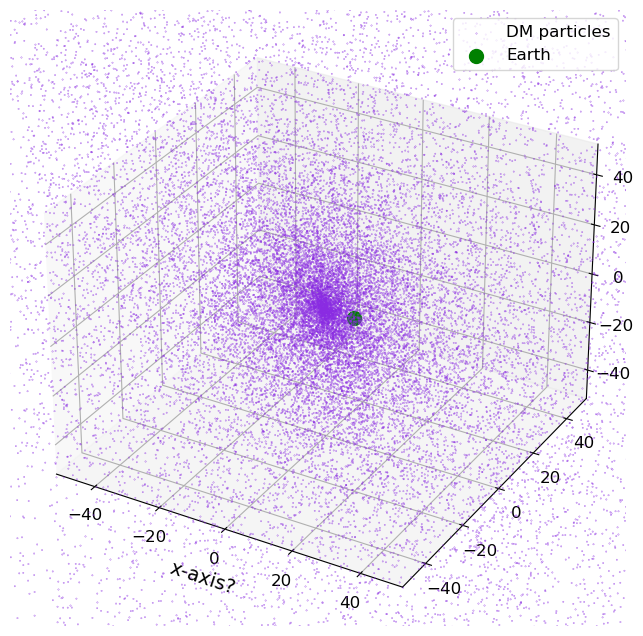

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=1, c='blueviolet', s=0.05, label='DM particles')
ax.scatter(8.5, 0., 0., c='green', s=100, label='Earth')
axlim = 50
ax.set_xlabel('x-axis?')
ax.set_xlim(-axlim, axlim)
ax.set_ylim(-axlim, axlim)
ax.set_zlim(-axlim, axlim)
plt.legend(loc='upper right')
plt.show()

In [ ]:
halo_batch_IDs = np.load(glob.glob(f'{sim_dir}/halo_batch*indices.npy')[0])

DM_raw = read_DM_halo_index(
    '0036', int(halo_batch_IDs[1]), '', 
    '/projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00', '', 
    direct=True
)

In [ ]:
from colorcet.plotting import swatch, swatches
import holoviews as hv
hv.extension('matplotlib')

swatches()